In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# v1
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

# v3
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.metrics import *
# v4

ACCURACY_LIST = []
from keras_resnet.models import ResNet50
from keras.layers import GlobalMaxPooling2D
from keras.models import Model

# v5
!pip install efficientnet
from efficientnet.keras import EfficientNetB4
from keras import backend as K

# v6
# Get reproducible results
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [7]:
metadata = pd.read_csv('Chest_xray_Corona_Metadata.csv')
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')

metadata.sample(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
4519,4519,person692_bacteria_2589.jpeg,Pnemonia,TRAIN,NaN,bacteria
3147,3147,person325_bacteria_1500.jpeg,Pnemonia,TRAIN,NaN,bacteria
3037,3037,person1945_bacteria_4872.jpeg,Pnemonia,TRAIN,NaN,bacteria
712,712,NORMAL2-IM-0490-0001.jpeg,Normal,TRAIN,NaN,NaN
5411,5434,NORMAL2-IM-0288-0001.jpeg,Normal,TEST,NaN,NaN
2126,2126,person1423_bacteria_3650.jpeg,Pnemonia,TRAIN,NaN,bacteria
5065,5065,person973_virus_1647.jpeg,Pnemonia,TRAIN,NaN,Virus
2639,2639,person1517_bacteria_3968.jpeg,Pnemonia,TRAIN,NaN,bacteria
3821,3821,person413_bacteria_1831.jpeg,Pnemonia,TRAIN,NaN,bacteria
416,416,IM-0616-0001.jpeg,Normal,TRAIN,NaN,NaN


In [8]:
train_data = metadata[metadata['Dataset_type'] == 'TRAIN']
test_data = metadata[metadata['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == metadata.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5675,5698,person112_bacteria_539.jpeg,Pnemonia,TEST,NaN,bacteria
5807,5830,person49_virus_101.jpeg,Pnemonia,TEST,NaN,Virus
5455,5478,NORMAL2-IM-0195-0001.jpeg,Normal,TEST,NaN,NaN
5609,5632,person134_bacteria_644.jpeg,Pnemonia,TEST,NaN,bacteria
5798,5821,person57_virus_113.jpeg,Pnemonia,TEST,NaN,Virus
5597,5620,person139_bacteria_661.jpeg,Pnemonia,TEST,NaN,bacteria
5895,5918,person1650_virus_2854.jpeg,Pnemonia,TEST,NaN,Virus
5671,5694,person113_bacteria_543.jpeg,Pnemonia,TEST,NaN,bacteria
5590,5613,person140_bacteria_668.jpeg,Pnemonia,TEST,NaN,bacteria
5869,5892,person1678_virus_2895.jpeg,Pnemonia,TEST,NaN,Virus


In [9]:
# Null value calculation
print(f"Count of null values in train :\n{train_data.isnull().sum()}")
print(f"Count of null values in test :\n{test_data.isnull().sum()}")

Count of null values in train :
Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5217
Label_1_Virus_category    1342
dtype: int64
Count of null values in test :
Unnamed: 0                  0
X_ray_image_name            0
Label                       0
Dataset_type                0
Label_2_Virus_category    624
Label_1_Virus_category    234
dtype: int64


In [10]:
# Substitute null values with string unknown
train_fill = train_data.fillna('unknown')
test_fill = test_data.fillna('unknown')

train_fill.sample(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
4724,4724,person605_virus_1169.jpeg,Pnemonia,TRAIN,unknown,Virus
991,991,NORMAL2-IM-0978-0001.jpeg,Normal,TRAIN,unknown,unknown
1601,1601,person1040_bacteria_2974.jpeg,Pnemonia,TRAIN,unknown,bacteria
428,428,IM-0606-0001.jpeg,Normal,TRAIN,unknown,unknown
2080,2080,person1271_bacteria_3231.jpeg,Pnemonia,TRAIN,unknown,bacteria
4768,4768,person870_bacteria_2792.jpeg,Pnemonia,TRAIN,unknown,bacteria
4352,4352,person549_bacteria_2305.jpeg,Pnemonia,TRAIN,unknown,bacteria
2690,2690,person1720_bacteria_4545.jpeg,Pnemonia,TRAIN,unknown,bacteria
2914,2914,person265_bacteria_1236.jpeg,Pnemonia,TRAIN,unknown,bacteria
3971,3971,person502_bacteria_2122.jpeg,Pnemonia,TRAIN,unknown,bacteria


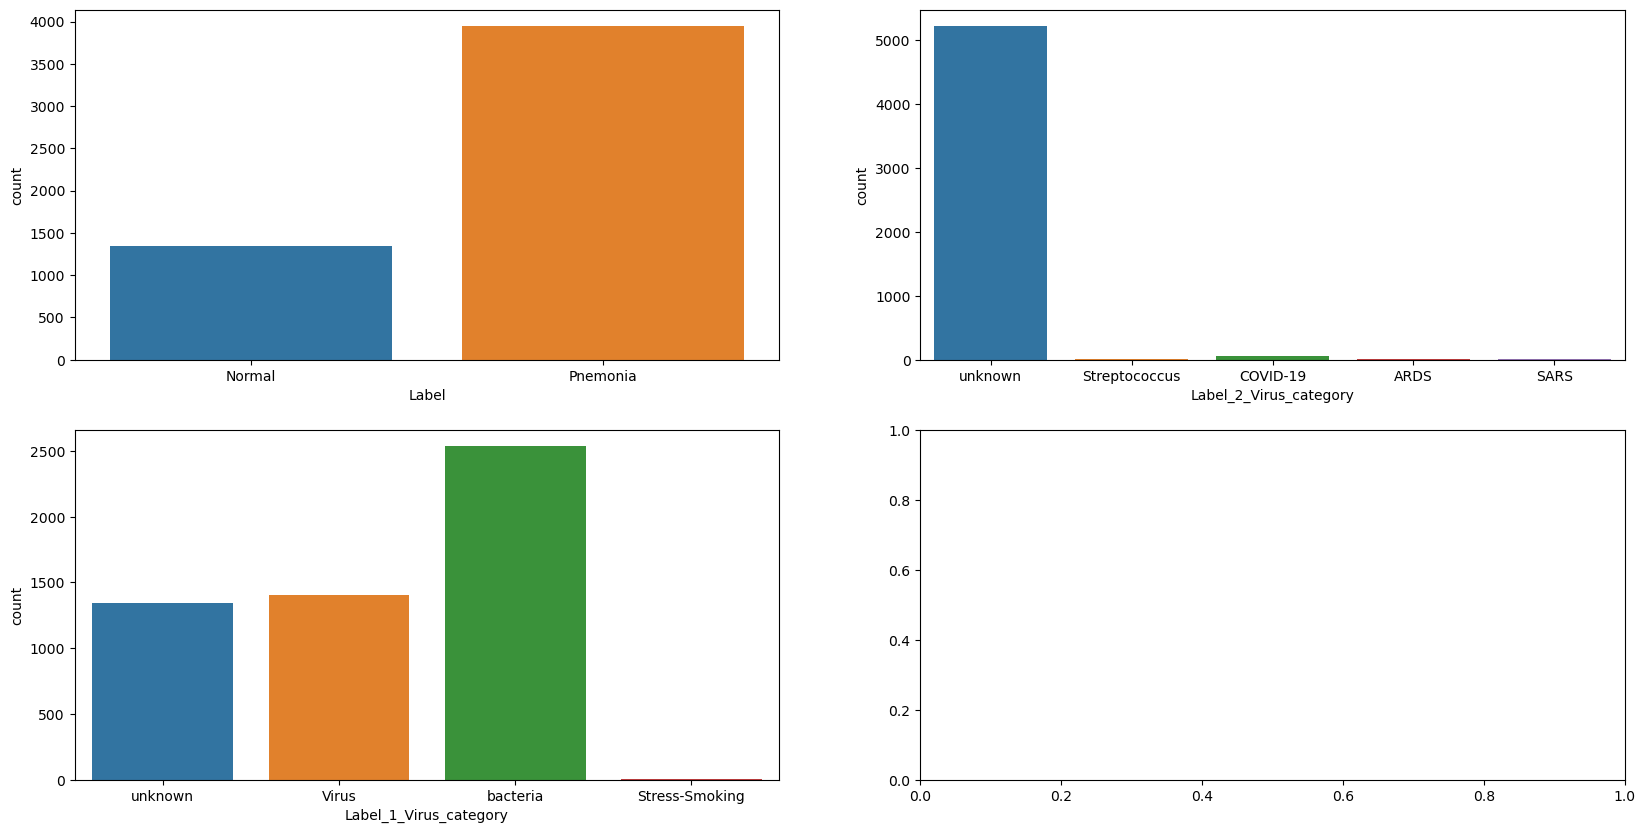

In [11]:
# Count plot for 3 attributes with unknown variable addition
targets = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_fill, ax=ax[0, 0])
sns.countplot(x=targets[1], data=train_fill, ax=ax[0, 1])
sns.countplot(x=targets[2], data=train_fill, ax=ax[1, 0])
plt.show()

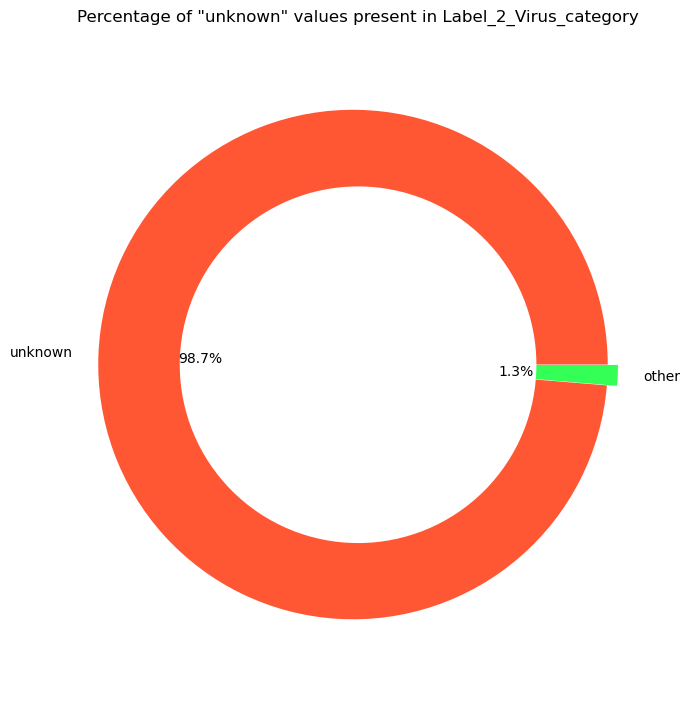

In [12]:
# Pie chart representation of Label_2_Virus_category values

colors = ['#ff5733', '#33ff57']
explode = [0.02, 0.02]

values = ['unknown', 'other']
percentages = [100 * (train_fill[train_fill[targets[1]] == 'unknown'].shape[0]) / train_fill.shape[0],
              100 * (train_fill[train_fill[targets[1]] != 'unknown'].shape[0]) / train_fill.shape[0]]

fig1, ax1 = plt.subplots(figsize=(7, 7))

plt.pie(percentages, colors=colors, labels=values,
        autopct='%1.1f%%', startangle=0, explode=explode)
fig = plt.gcf()
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()
plt.title('Percentage of "unknown" values present in Label_2_Virus_category')
plt.show()

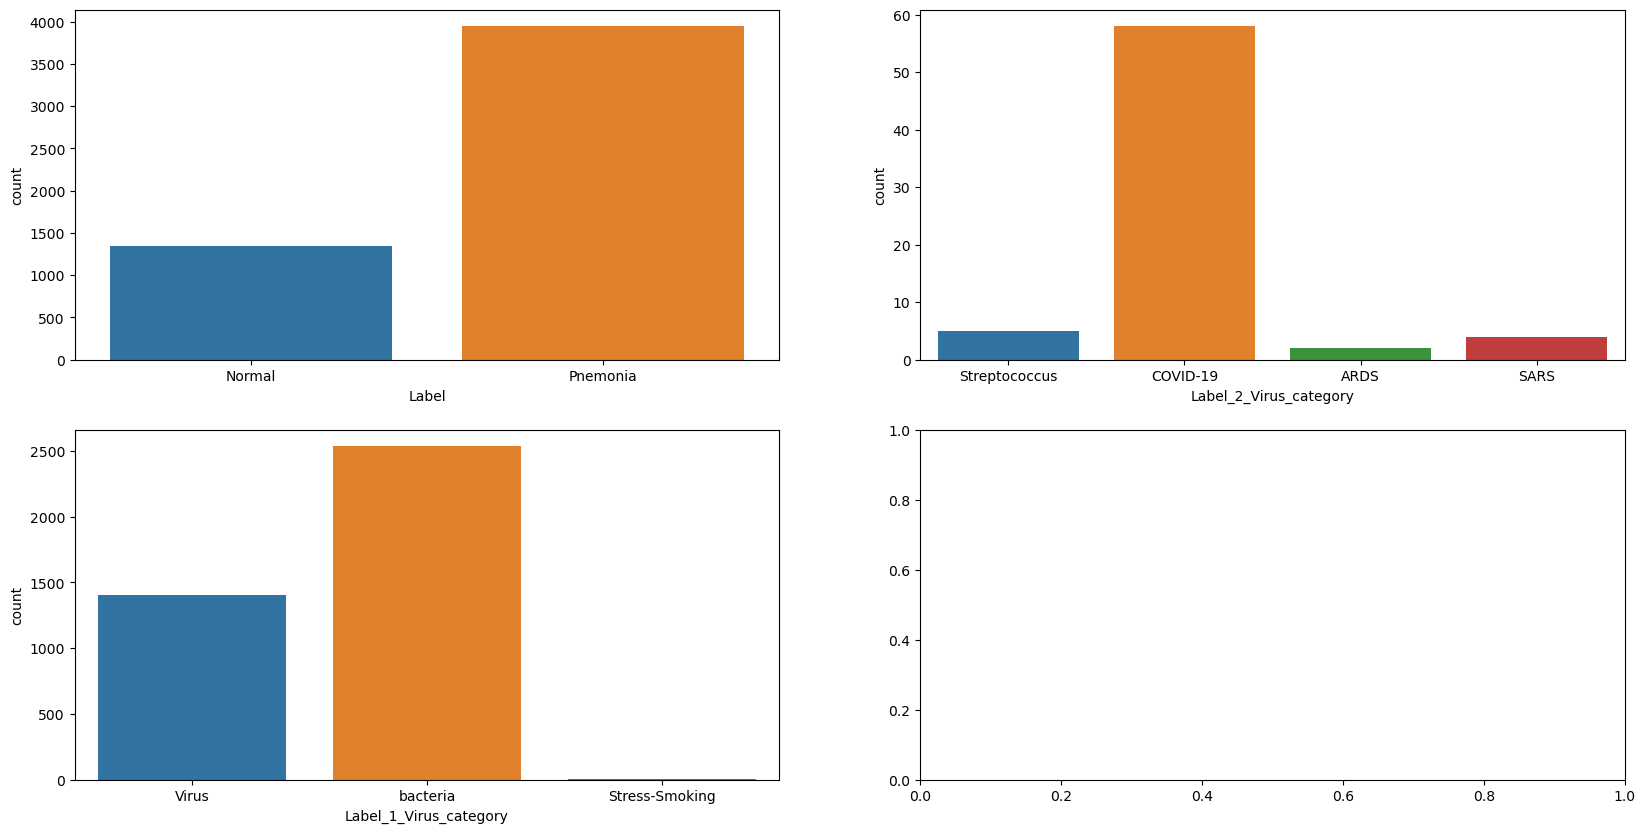

In [13]:
# Count plot for 3 target variables without filling unknown variable
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_data, ax=ax[0, 0])
sns.countplot(x=targets[1], data=train_data, ax=ax[0, 1])
sns.countplot(x=targets[2], data=train_data, ax=ax[1, 0])
plt.show()

In [14]:
print(f"Label = Normal Cases : {train_data[train_data['Label'] == 'Normal'].shape[0]}")
print(f"""Label = Pnemonia + Label_2_Virus_category = COVID-19 cases : {train_data[(train_data['Label'] == 'Pnemonia')
      & (train_data['Label_2_Virus_category'] == 'COVID-19')].shape[0]}""")
print(f"""Label = Normal + Label_2_Virus_category = COVID-19 cases : {train_data[(train_data['Label'] == 'Normal')
      & (train_data['Label_2_Virus_category'] == 'COVID-19')].shape[0]}""")

Label = Normal Cases : 1342
Label = Pnemonia + Label_2_Virus_category = COVID-19 cases : 58
Label = Normal + Label_2_Virus_category = COVID-19 cases : 0


Inference from count plots and Pie chart
All COVID-19 patients are classified with attribute Label as Pnemonia. None of them is classified as normal.
In target "Label_2_Virus_category", "unknown" value is associated with majority of images
Unknown values consist of 98.7 % of total cases while COVID-19 value consist of less than 1.3 % of total cases.